# 3-Sphere Microswimmer Simulation and Optimization
This notebook acompanies the paper...

## Imports
for computational speed thanks to just-in-time compilation and the autodifferentiation framework we use the JAX ecosystem

In [8]:
import jax
jax.config.update("jax_enable_x64", True) ## otherwise stiff ODE solver fails
from jaxtyping import ArrayLike, PyTree, Float, Int
from typing import List, Tuple, Dict, Any, Union
from jax.lax import while_loop
import jax.numpy as jnp
import diffrax as dfx
import optimistix 
import optax
from evosax.algorithms import CMA_ES
import equinox as eqx
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import pandas as pd
import os
import matplotlib.animation as animation
import mediapy
from matplotlib.animation import PillowWriter
from matplotlib.patches import Ellipse
from abc import abstractmethod
from typing import Callable
from scipy.integrate import solve_ivp
import logging
from uncertainties import ufloat
from functools import partial
from tqdm.auto import tqdm
from operator import sub

import scienceplots
from matplotlib import rc
from cycler import cycler
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use(['science'])
rc('font', **{'family': 'serif', 'serif': ['cmr10'], 'size': 10})
rc('figure.constrained_layout', use=True)
rc('text', usetex=True)
rc('lines', linewidth=2)
rc('axes.formatter', use_mathtext=True)
plt.rcParams.update({'figure.dpi': '100'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors.append('tab:pink')
plt.rcParams['axes.prop_cycle'] =  cycler(color=colors)

comp_cycler = (cycler(color=colors[:3]) + cycler(lw=[2, 2, 2]) + cycler(linestyle=['-', '--', '-.']))

In [9]:
# logging.basicConfig(level=logging.INFO)

## Simulation

### BField
we want our swimmer to respond to arbitrary driving magnetic fields, thus we define an abstract base class (module) BField

a few concrete subclasses for different forms of parametrized fields are provided

In [10]:
class BField(eqx.Module):
    period: Float
    dbdt: Float

    @abstractmethod
    def __call__(self, t: Float) -> Float:
        raise NotImplementedError
    

class CosBField(BField):
    period: Float
    dbdt: Float
    b_min: Float
    b_max: Float
    omega: Float
    phi0: Float

    def __init__(self, b_min=0., b_max=1., dbdt=None, omega=None, phi0=0.15):
        self.b_min, self.b_max = jnp.sort(jnp.array([b_min, b_max]))
        self.phi0 = phi0
        if omega is not None and dbdt is None:
            self.omega = jnp.maximum(omega, 1e-10)
            self.dbdt = self.omega * (self.b_max - self.b_min) / 2.
        elif omega is None and dbdt is not None:
            self.dbdt = jnp.maximum(dbdt, 1e-10)
            self.omega = 2 * self.dbdt / (self.b_max - self.b_min)
            
        else:
            raise ValueError("Either omega or dbdt must be provided, but not both.")
        self.period = 2 * jnp.pi / self.omega

    def __call__(self, t: Float) -> Float:
        return (self.b_min + self.b_max) / 2 + (self.b_max - self.b_min) / 2 * jnp.cos(self.omega * t + self.phi0)


class BangBangConstBField(BField):
    period: Float
    dbdt: Float
    b: ArrayLike
    t: ArrayLike
    b_interp: dfx.LinearInterpolation
    phi0: Float

    def __init__(self, b_list=(1.0, 0.3, 0, 0.7), t_list=(1,1,1,1), dbdt=1.0, phi0=0.15):
        self.dbdt = jnp.maximum(dbdt, 1e-10)
        self.b = jnp.clip(jnp.array([x for x in b_list for _ in range(2)] + [b_list[0]]), -10, 10)
        self.t = jnp.zeros_like(self.b)
        for (i, t_int) in enumerate(t_list):
            self.t = self.t.at[2*i+1].set(self.t[2*i] + t_int)
            self.t = self.t.at[2*i+2].set(self.t[2*i+1] + jnp.abs(b_list[(i+1)% 4] - b_list[i]) / self.dbdt)
        self.period = self.t[-1]
        self.b_interp = dfx.LinearInterpolation(self.t, self.b)
        self.phi0 = phi0

    def __call__(self, t_eval: Float) -> Float:
        return self.b_interp.evaluate((t_eval + self.phi0* self.period) % self.period)
    

class BangBangBField(BField):
    period: Float
    dbdt: Float
    bs : ArrayLike
    ts : ArrayLike
    b_clip : Float
    b_interp : dfx.LinearInterpolation
    phi0: Float
    
    def __init__(self, b_list=(0.45, 0.15), b_clip=1., dbdt=1., phi0=0.3):
        self.dbdt = dbdt
        self.bs = jnp.array(list(b_list) + [b_list[0]])
        self.ts = jnp.zeros_like(self.bs)
        self.b_clip = b_clip
        for i in range(len(b_list)):
            self.ts = self.ts.at[i+1].set(self.ts[i] + jnp.abs(self.bs[i+1] - self.bs[i]) / self.dbdt)
        self.period = self.ts[-1]
        self.b_interp = dfx.LinearInterpolation(self.ts, self.bs)
        self.phi0 = phi0

    def __call__(self, t_eval: Float) -> Float:
        return jnp.clip(self.b_interp.evaluate((t_eval + self.phi0 * self.period) % self.period), 0., self.b_clip)

### Swimmer
all the physical parameters, the rhs of the ODE and some usefull functions are stored in this class

In [11]:
class Swimmer(eqx.Module):
    # physical design parameters
    # rest lengths
    l1: Float 
    l2: Float
    # maximum extensibility from rest length
    l1_max: Float
    l2_max: Float
    # stiffness
    k1: Float
    k2: Float
    chi_a: Float  # apparent magnetic susceptibility of the spheres
    check_invariants: bool
    
    def __init__(self, l1=8.47, l2=13.305, c1=1.119, c2=1.442, k1=None, k2=None, l1_max=None, l2_max=None, lmin=4.0, length_scale=1e-6, check_invariants=True, chi_a=3.):
        self.check_invariants = check_invariants
        self.l1 = l1
        self.l2 = l2
        self.chi_a = chi_a
        if c1 is not None:
            self.k1 = c1 / l1 ** 5
        elif k1 is not None:
            self.k1 = k1
        else:
            raise ValueError("Either c1 or k1 must be provided.")
        
        if c2 is not None:
            self.k2 = c2 / l2 ** 5
        elif k2 is not None:
            self.k2 = k2
        else:
            raise ValueError("Either c2 or k2 must be provided.")
        if l1_max is not None:
            self.l1_max = l1_max
        else:
            self.l1_max = l1 - lmin
        if l2_max is not None:
            self.l2_max = l2_max
        else:
            self.l2_max = l2 - lmin
        if not self.check_invariants:
            self.l1 = jnp.maximum(self.l1, lmin + 1e-2)
            self.l2 = jnp.maximum(self.l2, lmin + 1e-2)
            self.k1 = jnp.maximum(self.k1, 1e-15)
            self.k2 = jnp.maximum(self.k2, 1e-15)
            self.l1_max = jnp.clip(self.l1_max, 1e-2, self.l1 - lmin)
            self.l2_max = jnp.clip(self.l2_max, 1e-2, self.l2 - lmin)

        logging.debug(f"created Swimmer: {self.__dict__}")
  

    def __check_init__(self):
        if getattr(self, "check_invariants", True):
            assert self.l1_max > 0, "l1_max must be positive"
            assert self.l2_max > 0, "l2_max must be positive"
            assert self.l1 > self.l1_max + 2, "l1 must be greater than l1_max + 2"
            assert self.l2 > self.l2_max + 2, "l2 must be greater than l2_max + 2"
            assert self.k1 > 0, "k1 must be positive"
            assert self.k2 > 0, "k2 must be positive"
            logging.debug(f"checked all conditions")

    # this transformation from y to x variables guarantees the physical constraints of the FENE springs, 
    # the singularities of the potential then lie at infinity in y space
    def tanh_transform(self, y: ArrayLike) -> ArrayLike:
        y1, y2, y3 = y
        x1 = y2 - self.l1 - self.l1_max * jnp.tanh(y1)
        x2 = y2
        x3 = y2 + self.l2 + self.l2_max * jnp.tanh(y3)
        return jnp.stack([x1, x2, x3])

    # inverse transformation from x to y variables
    def atanh_transform(self, x: ArrayLike) -> ArrayLike:
        x1, x2, x3 = x
        y1 = jnp.atanh((x2 - x1 - self.l1) / self.l1_max)
        y2 = x2
        y3 = jnp.atanh((x3 - x2 - self.l2) / self.l2_max)
        return jnp.stack([y1, y2, y3])


    def ode_rhs(self, b: BField, with_e=False, order=6, tanh_transform=False) -> Callable:
        
        @jax.jit
        def fun(t: float, y: ArrayLike, args=None) -> ArrayLike:
            if with_e:
                y1, y2, y3, e = y
            else:
                y1, y2, y3 = y
            
            l1, l2, k1, k2, l1_max, l2_max = self.l1, self.l2, self.k1, self.k2, self.l1_max, self.l2_max

            if tanh_transform:
                x12 = l1 + l1_max * jnp.tanh(y1)
                x23 = l2 + l2_max * jnp.tanh(y3)
                singularity_1 = jnp.cosh(y1) ** 2
                singularity_2 = jnp.cosh(y3) ** 2
            else:
                eps = 1e-8
                x12 = jnp.maximum(y2 - y1, l1 - l1_max)
                x23 = jnp.maximum(y3 - y2, l2 - l2_max)
                singularity_1 = 1 / jnp.maximum(1 - ((x12 - l1) / l1_max) ** 2, eps) 
                singularity_2 = 1 / jnp.maximum(1 - ((x23 - l2) / l2_max) ** 2, eps)

            x13 = x12 + x23

            b_sq = b(t) ** 2

            F12 = b_sq * x12 ** (-4) + k1 * (x12 - l1) * singularity_1
            F23 = b_sq * x23 ** (-4) + k2 * (x23 - l2) * singularity_2
            F13 = b_sq * x13 ** (-4)

            F1 = F12 + F13
            F2 = F23 - F12
            F3 = -F23 - F13

            M12 = 1.5 / x12
            M13 = 1.5 / x13
            M23 = 1.5 / x23
            M11 = 1
            M22 = 1
            M33 = 1

            if order >= 3:
                M12 -= x12 ** (-3)
                M13 -= x13 ** (-3)
                M23 -= x23 ** (-3)

            if order >= 4:
                M12 -= 3.75 * (x13 ** (-2) * x23 ** (-2))
                M13 += 3.75 * (x12 ** (-2) * x23 ** (-2))
                M23 -= 3.75 * (x12 ** (-2) * x13 ** (-2))
                M11 -= 3.75 * (x12 ** (-4) + x13 ** (-4))
                M22 -= 3.75 * (x12 ** (-4) + x23 ** (-4))
                M33 -= 3.75 * (x13 ** (-4) + x23 ** (-4))

            if order >= 6:
                M12 += 6 * x13 ** (-2) * x23 ** (-2) * (x13 ** (-2) + x23 ** (-2)) - 6.5 * x13 ** (-3) * x23 ** (-3)
                M13 += - 6 * x12 ** (-2) * x23 ** (-2) * (x12 ** (-2) + x23 ** (-2)) - 6.5 * x12 ** (-3) * x23 ** (-3)
                M23 += 6 * x12 ** (-2) * x13 ** (-2) * (x12 ** (-2) + x13 ** (-2)) - 6.5 * x12 ** (-3) * x13 ** (-3)
                M11 += 5.5 * (x12 ** (-6) + x13 ** (-6))
                M22 += 5.5 * (x12 ** (-6) + x23 ** (-6))
                M33 += 5.5 * (x13 ** (-6) + x23 ** (-6))

            v1 = (F1 * M11 + F2 * M12 + F3 * M13)
            v2 = (F1 * M12 + F2 * M22 + F3 * M23)
            v3 = (F1 * M13 + F2 * M23 + F3 * M33)


            if tanh_transform:
                # dxdy = l_max * jnp.cosh(y) ** (-2), dydx = 1/dxdy = singularity / l_max
                dydt = jnp.stack([singularity_1 / l1_max * (v2 - v1), v2, singularity_2 / l2_max * (v3 - v2)])
            else:
                dydt = jnp.stack([v1, v2, v3])

            if with_e:
                p = (F1 * v1 + F2 * v2 + F3 * v3) 
                dydt = jnp.append(dydt, p)

            return dydt * 1e6
    
        return fun

    # approximate solution for the collapse position, obtained by series expansion around the pole, valid for strong fields
    def x_collapse_approx(self, b: Float) -> ArrayLike:
            return jnp.array([- self.l1 + self.l1_max * (1 - self.k1 * self.l1_max / (2 * b**2 * ((self.l1 - self.l1_max) ** (-4) + (self.l1 - self.l1_max + self.l2 - self.l2_max) ** (-4)) + self.k1 * self.l1_max)), 
                              0, 
                              self.l2 - self.l2_max * (1 - self.k2 * self.l2_max / (2 * b**2 * ((self.l2 - self.l2_max) ** (-4) + (self.l1 - self.l1_max + self.l2 - self.l2_max) ** (-4)) + self.k2 * self.l2_max))])
    
    # exact solution for the collapse position, obtained by numerical root finding
    def x_collapse_exact(self, b, tol=1e-6) -> ArrayLike:
        l1, l2, k1, k2, l1_max, l2_max = self.l1, self.l2, self.k1, self.k2, self.l1_max, self.l2_max
        eps = 1e-5

        def forces(x: ArrayLike, b: Float=None) -> ArrayLike:
            eps = 1e-5
            b_sq = b ** 2

            x12, x23 = -x[0], x[1]
            x13 = x12 + x23

            F12 = b_sq * x12 ** (-4) + k1 * (x12 - l1) / jnp.maximum(1 - ((x12 - l1) / l1_max) ** 2, eps)
            F23 = b_sq * x23 ** (-4) + k2 * (x23 - l2) / jnp.maximum(1 - ((x23 - l2) / l2_max) ** 2, eps)
            F13 = b_sq * x13 ** (-4)
            return jnp.array([F12 + F13, -F23 - F13])
        
        x10, _, x30 = self.x_collapse_approx(b)
        y0 =  jnp.array([x10, x30])
        result = optimistix.root_find(forces, args=b, solver=optimistix.BestSoFarRootFinder(optimistix.Newton(rtol=tol, atol=tol)), y0=y0, throw=False, 
                                      options={"lower": jnp.array([-l1 - l1_max + eps, l2 - l2_max + eps]), 
                                               "upper": jnp.array([-l1 + l1_max - eps, l2 + l2_max - eps])}, max_steps=2**10)
        logging.info(f"optimistix result: {result.value}\nstats: {result.stats}")
        x1, x3 = result.value
        if (error := optimistix.RESULTS[result.result]) == '':
            return jnp.array([x1, 0, x3])
        logging.debug(f"otimistix failed: {error}")
        return jnp.array([x10, 0, x30])

### Experiment
the experiment brings together both a BField and a Swimmer and packages functions to simulate trajectories, find stationary velocities and plot

In [20]:
class Experiment(eqx.Module):
    swimmer: Swimmer
    b_field: BField
    n_cycles_max: float
    atol: float
    mu_0: float = 4e-7 * jnp.pi
    eta: float
    spring_constant_scale: float
    time_scale: float
    length_scale: float # radius of the spheres
    dBdt_scale: Float
    energy_scale: Float
    velocity_scale: Float
    B_scale: Float 
    rho: Float

    def __init__(self, swimmer: Swimmer, b_field: BField, n_cycles_max=20, atol=1e-3, eta=7e-4, B_scale=0.1, a=1.0e-6, rho=1000.):
        self.swimmer = swimmer
        self.b_field = b_field
        self.n_cycles_max = n_cycles_max
        self.eta = eta  # Pa s, viscosity of the fluid (Blood 3e-3, Water 7e-4)
        self.rho = rho  # kg/m^3 density of the fluid
        self.length_scale = a # radius of the spheres 1 mu m
        self.B_scale = B_scale # in Tesla
        self.time_scale = 1e6 * 9 * self.eta * self.mu_0 / (4 * self.swimmer.chi_a ** 2 * self.B_scale ** 2)
        self.dBdt_scale = self.B_scale / self.time_scale
        self.spring_constant_scale = 8 * jnp.pi * self.swimmer.chi_a ** 2 * self.length_scale * self.B_scale / (3 * self.mu_0) 
        self.energy_scale = self.spring_constant_scale * self.length_scale ** 2
        self.velocity_scale = self.length_scale / self.time_scale
        self.atol = atol
        logging.debug(f"created Experiment: {self.__dict__}")
    
    def __check__init__(self):
        assert isinstance(self.swimmer, Swimmer), "swimmer must be an instance of Swimmer"
        assert isinstance(self.b_field, BField), "b_field must be an instance of BField or its subclasses"
        assert self.headstart >= 0, "headstart must be non-negative"
        assert self.n_cycles_max > 0, "n_cycles_max must be positive"
        logging.debug(f"checked all conditions")

    @partial(jax.jit, static_argnames=('with_e', 'order', 'tanh_transform', 'dense'))
    def run(self, n_cycles=1., t_eval=None, x0=None, with_e=False, headstart=0.0, tanh_transform=False, dense=False, order=7) -> dfx.Solution:
        ode_term = dfx.ODETerm(self.swimmer.ode_rhs(self.b_field, with_e=with_e, order=order, tanh_transform=tanh_transform))
        t0 = - headstart * self.b_field.period
        t1 = n_cycles * self.b_field.period
        # if t_eval is not None:
        #     t0 = jnp.minimum(jnp.min(t_eval), t0)
        #     t1 = jnp.maximum(jnp.max(t_eval), t1)
        if x0 is None:
            x0 = self.swimmer.x_collapse_approx(self.b_field(t0))
            if tanh_transform:
                x0 = self.swimmer.atanh_transform(x0)
        y0 = x0 if not with_e else jnp.append(x0, 0.0)
        dt0 = 0.0002
        solver = dfx.Kvaerno5()
        saveat = dfx.SaveAt(ts=t_eval, dense=dense, steps=(t_eval is None))
        stepsize_controller = dfx.PIDController(rtol=0, atol=self.atol, icoeff=0.3, pcoeff=0.1)
        return dfx.diffeqsolve(
            ode_term,
            solver,
            t0,
            t1,
            dt0,
            y0,
            max_steps=2**13,
            saveat=saveat,
            throw=False,
            stepsize_controller=stepsize_controller
        )
    
    def find_periodic_state_iteratively(self, headstart=0.3, x0=None, order=7) -> tuple[ArrayLike, Float, Float]:
        t_eval = jnp.array([0, self.b_field.period])
        sol = self.run(n_cycles=1 + 1e-6, x0=x0, headstart=headstart, t_eval=t_eval, order=order)
        res_init = jnp.linalg.norm(jnp.diff(sol.ys[1]) - jnp.diff(sol.ys[0]))
        x0_init = sol.ys[0]
        v_init = jnp.mean(sol.ys[1] - sol.ys[0]) / self.b_field.period

        def cond_fun(state):
            i, x0, res, v = state
            return jnp.logical_and(i < self.n_cycles_max, res >= self.atol)

        def body_fun(state):
            i, x0, res, v = state
            sol_new = self.run(n_cycles=1, headstart=0.0, x0=x0, t_eval=t_eval)
            x0_new = sol_new.ys[1] - sol_new.ys[1,1]
            res_new = jnp.linalg.norm(jnp.diff(sol_new.ys[1]) - jnp.diff(sol_new.ys[0]))
            v_new = jnp.mean(sol_new.ys[1] - sol_new.ys[0]) / self.b_field.period
            return (i + 1, x0_new, res_new, v_new)

        x0_init = sol.ys[0]
        x1_init = sol.ys[1] - sol.ys[1,1]
        res_init = jnp.linalg.norm(jnp.diff(x1_init) - jnp.diff(x0_init))
        state_init = (0, x0_init, res_init, v_init)

        i_final, x0_final, res_final, steady_state_velocity = jax.lax.while_loop(cond_fun, body_fun, state_init)
      
        logging.info(f'Periodic state found: {x0_final} with residue {res_final} after {i_final} cycles')

        v_error = jnp.linalg.norm(res_final) / self.b_field.period
        return x0_final - x0_final[1], steady_state_velocity, v_error

    def velocity_and_residue(self, x0=None, headstart=0.3, order=7) -> tuple[Float, Float]:
        t_eval = jnp.array([0, 1]) * self.b_field.period
        sol = self.run(n_cycles=1., x0=x0, t_eval=t_eval, headstart=headstart, order=order)
        residue = jnp.diff(sol.ys[1]) - jnp.diff(sol.ys[0])
        v_error = jnp.linalg.norm(residue) / self.b_field.period
        v = jnp.mean(sol.ys[1] - sol.ys[0]) / self.b_field.period
        return v, v_error

    def _draw_swimmer(self, ax, x_positions, t, sphere_colors=("C2", "C1", "C0"), spring_color="C4", alpha=0.7, r=1.0):
        """Draw swimmer configuration with three spheres and springs"""
        x1, x2, x3 = x_positions
        
        def get_aspect(ax):
            # Total figure size
            bbox = ax.get_window_extent().transformed(ax.get_figure().dpi_scale_trans.inverted())
            ax_w, ax_h = bbox.width, bbox.height
            # Axis size on figure
            _, _, w, h = ax.get_position().bounds
            # Ratio of display units
            disp_ratio = (ax_h * h) / (ax_w * w)
            # Ratio of data units
            data_ratio = sub(*ax.get_ylim()) / sub(*ax.get_xlim())

            return disp_ratio / data_ratio
    
        aspect = get_aspect(ax)
        
        # Draw spheres with corrected radius
        for x_pos, color in zip([x1, x2, x3], sphere_colors):
            circle = Ellipse((t, x_pos), height=2 * r, width=2 * r * aspect, 
                          color=color, alpha=alpha, zorder=10)
            ax.add_patch(circle)
        
        # Draw springs as zigzag lines
        def draw_spring(ax, x_start, x_end, t, n_coils, relative_spring_width=0.7, lw=1, color='blue', alpha=0.7):
            # Correct spring radius for aspect ratio
            corrected_spring_radius = relative_spring_width * r * aspect

            x_spring = jnp.linspace(x_start, x_end, int(n_coils * 6 + 1))
            t_spring = t + jnp.sin(jnp.linspace(0, n_coils * 2 * jnp.pi, len(x_spring))) * corrected_spring_radius

            ax.plot(t_spring, x_spring, color=spring_color, alpha=alpha, linewidth=lw, zorder=5)
        
        # Draw springs between spheres with corrected spacing
        draw_spring(ax, x1 + r, x2 - r, t, int(self.swimmer.l1) / 2)
        draw_spring(ax, x2 + r, x3 - r, t, int(self.swimmer.l2) / 2)

    def plot(self, n_cycles=3, x0=None, headstart=0, display_swimmer_times: ArrayLike = jnp.array([]), with_e=True, order=6,
             trajectory_args={}, bfield_args={}, energy_args={"marker":'x', "markersize":4}, compute_velocity=True, axs=None):
        if any(display_swimmer_times < 0) or any(display_swimmer_times > n_cycles * self.b_field.period):
            raise ValueError("display_swimmer_times must be within the simulation time [0, n_cycles * period]")
        
        if axs is None:
            fig, axs = plt.subplots(2 + with_e, 1, figsize=(10., 8. + 2.*with_e), sharex=True, height_ratios=[3, 1] + with_e * [1])
        if with_e:
            ax1, ax2, ax3 = axs
        else:
            ax1, ax2 = axs

        if x0 is None:
            x0, v, v_error = self.find_periodic_state_iteratively(headstart=headstart)
        elif compute_velocity:
            v, v_error = self.velocity_and_residue(x0=x0, headstart=headstart)
        
        res = self.run(n_cycles=n_cycles, x0=x0, headstart=headstart, with_e=True, dense=len(display_swimmer_times) > 0)

        ax1.plot(res.ts, res.ys[:, 2::-1], label=[r'$x3$', r'$x2$', r'$x1$'], **trajectory_args)
        
        if compute_velocity:
            ax1.plot(res.ts, res.ts*v + res.ys[0,1], ls="--", lw=1, label='x=vt')
        
        # Draw swimmer configurations at specified times
        if len(display_swimmer_times) > 0:
            
            for i, t_display in enumerate(display_swimmer_times):
                x_at_t = res.interpolation.evaluate(t_display)[:3]
                
                # Position swimmer drawings at different y-offsets
                self._draw_swimmer(ax1, x_at_t, t_display)
        
        ax1.set_ylabel(r'$x/a$')
        ax1.legend()
        if compute_velocity:
            ax1.set_title(fr'v = ${ufloat(v, v_error)}$')
        tlinspace = jnp.linspace(0, n_cycles * self.b_field.period, 1000)
        ax2.plot(tlinspace, self.b_field(tlinspace), **bfield_args)
        ax2.set_ylabel(r'$B/B_{max}$')
        if with_e:
            ax3.plot(res.ts, res.ys[:, 3] - res.ys[0,3], **energy_args)
            ax3.set_ylabel(r'$Dissipated Energy$')
            ax3.set_xlabel(r'$t$')
        fig.subplots_adjust(hspace=0, wspace=0)
        for ax in axs:
            ax.grid()
            ax.set_xbound(jnp.array([0, n_cycles]) * self.b_field.period)
        fig.tight_layout()
        plt.show()

        # summary in dimensionful units
        max_idx = jnp.argmin(jnp.isfinite(res.ts))
        instantaneous_vel = np.diff(res.ys[:max_idx,:3], axis=0) / np.diff(res.ts[:max_idx], axis=0).reshape(-1,1)
        max_v = jnp.max(instantaneous_vel)
        max_v_time = res.ts[jnp.argmax(instantaneous_vel) % instantaneous_vel.shape[0]]
        print(f"Max instantaneous velocity: {max_v * self.velocity_scale:2e} m/s at time {max_v_time:2f}")
        if compute_velocity:
            print(f"Average velocity: {v * self.velocity_scale:2e} m/s ")
        print(f"Reynolds Number: {2 * self.rho * max_v * self.velocity_scale * self.length_scale / self.eta:2e}")
        print(f"Total dissipated energy per period: {(res.ys[max_idx-1,3] - res.ys[0,3]) / n_cycles * self.energy_scale:2e} J")
        print(f"maximum Magnetic field strength: {jnp.max(self.b_field(res.ts[:max_idx])) * self.B_scale:2e} T")
        print(f"maximum dB/dt: {jnp.max(jnp.abs(jnp.diff(self.b_field(res.ts[:max_idx])) / jnp.diff(res.ts[:max_idx])) ) * self.dBdt_scale:2e} T/s")
        print(f"Field period = {self.b_field.period * self.time_scale:2e} s and frequency = {1 / (self.b_field.period * self.time_scale):2e} Hz")
        print(f"spring constants: k1 = {self.swimmer.k1 * self.spring_constant_scale:2e} N/m, k2 = {self.swimmer.k2 * self.spring_constant_scale:2e} N/m")


### Examples

order 6:  0.48274021993263616 1.497112368339558e-07
order 4:  0.4800696421547331 7.628669262922371e-08


/tmp/ipykernel_51701/844300446.py:192: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)
/tmp/ipykernel_51701/844300446.py:196: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


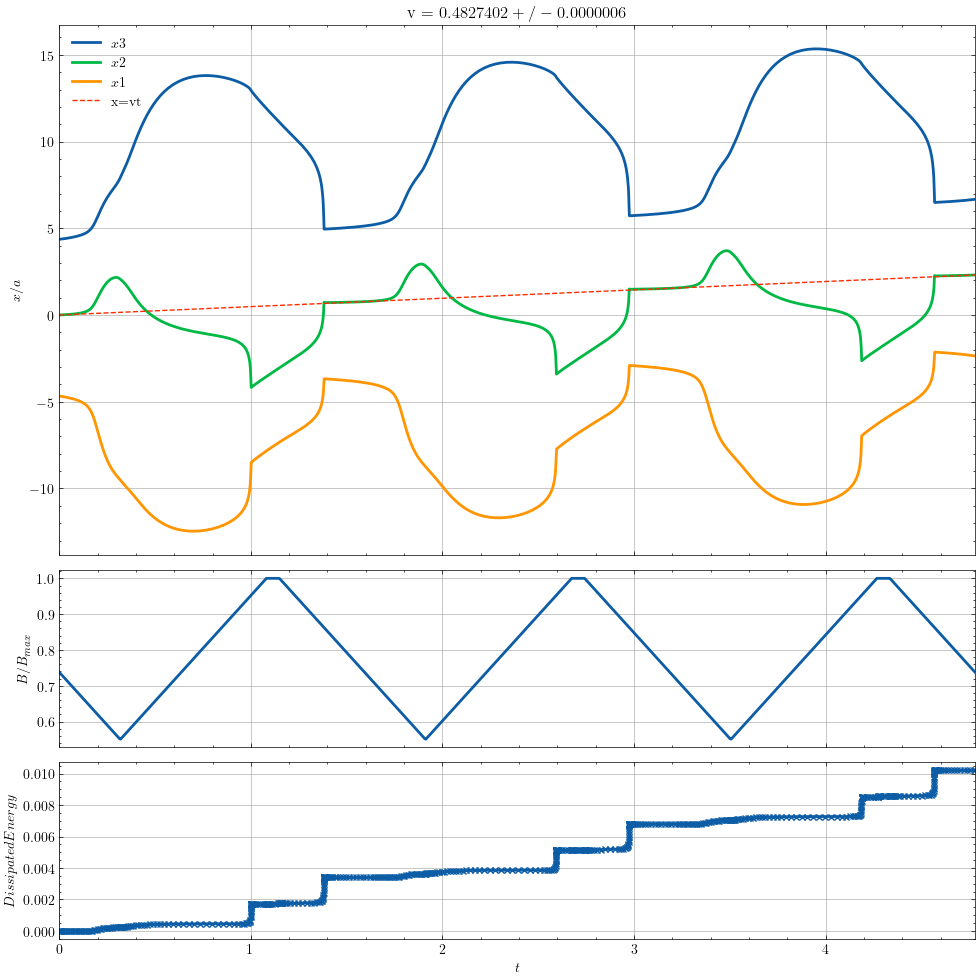

Max instantaneous velocity: 2.187669e-02 m/s at time 2.593834
Average velocity: 2.195157e-05 m/s 
Reynolds Number: 6.250482e-02
Total dissipated energy per period: 2.043619e-14 J
maximum Magnetic field strength: 1.000000e-01 T
maximum dB/dt: 2.682898e+00 T/s
Field period = 3.503675e-02 s and frequency = 2.854146e+01 Hz
spring constants: k1 = 1.212737e-04 N/m, k2 = 4.141262e-05 N/m


In [36]:
ex = Experiment(Swimmer(c1=8.1, c2=9.8, l1=13.2, l2=17.), BangBangBField(dbdt=0.59, b_clip=1., phi0=0.3, b_list=(1.02, 0.55)), atol=1e-6)
x0, v, verr = ex.find_periodic_state_iteratively(headstart=0.3, order=6)
print("order 6: ", v, verr)
x0, v, verr = ex.find_periodic_state_iteratively(headstart=0.3, order=4)
print("order 4: ", v, verr)
# sol = ex.run(n_cycles=3, x0=x0, with_e=False)
# df = pd.DataFrame({'t': sol.ts, 'x1': sol.ys[:,0], 'x2': sol.ys[:,1], 'x3': sol.ys[:,2], 'h': ex.b_field(sol.ts)})
# df.to_csv(f'data/trajectory_bang_bang_opt.csv', index=False)
ex.plot()

#### Individual Control of two swimmers

In [ ]:
sw1 = Swimmer(c1=8.1, c2=9.8, l1=13.2, l2=17.)
sw2 = Swimmer(c1=6.0, c2=6.9, l1=13., l2=17.)
bf = BangBangBField(dbdt=0.59, b_clip=1., phi0=0, b_list=[1.02, 0.55] * 15 + [0.9, 0.45] * 20)
ex1 = Experiment(sw1, bf, atol=1e-6)
sol = ex1.run(n_cycles=1, with_e=False)
df = pd.DataFrame({'t': sol.ts, 'x1': sol.ys[:,0], 'x2': sol.ys[:,1], 'x3': sol.ys[:,2], 'h': ex1.b_field(sol.ts)})
df.to_csv(f'data/trajectory_individual_control_1.csv', index=False)

ex2 = Experiment(sw2, bf, atol=1e-6)
sol = ex2.run(n_cycles=1, with_e=False)  
df = pd.DataFrame({'t': sol.ts, 'x1': sol.ys[:,0], 'x2': sol.ys[:,1], 'x3': sol.ys[:,2], 'h': ex2.b_field(sol.ts)})
df.to_csv(f'data/trajectory_individual_control_2.csv', index=False)

## different regimes

### quasistatic / slow b-field
when varying the magnetic field slowly, the swimmer is always very close to the equilibrium

minimum velocity at l_ratio = 0.9968688845401174, c_ratio = 1.0 with value -0.0002839947999788
maximum velocity at l_ratio = 0.9154598825831702, c_ratio = 0.9107632093933463 with value 0.0009350225586194


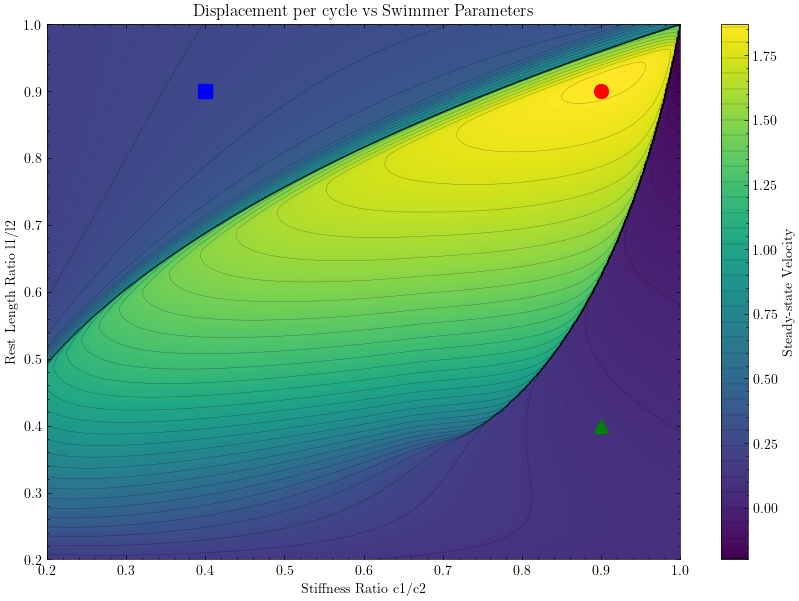

In [25]:
def plot_velocity_vs_parameters(l_res=512, c_res=512, force_reload=False, ax=None, samples=[(0.9, 0.9), (0.9,0.4), (0.4, 0.9)], colors=['red', 'blue', 'green'], shapes=['o', 's', '^'], labls=['a', 'b', 'c'], dbdt=1e-3, verbose=True):
    filename = f"data/velocity_grid_dbdt_1e3_l2_25_c2_10_lmin_4_lr_{l_res}_cr_{c_res}.csv"

    if not os.path.exists(filename) or force_reload:
        
        l_ratio = jnp.linspace(0.2, 1., l_res)
        c_ratio = jnp.linspace(0.2, 1., c_res)

        @jax.jit
        @partial(jax.vmap, in_axes=(None, 0))
        def velocity(l_ratio, c_ratio):
            l2 = 25.
            l1 = l_ratio * l2
            c2 = 10.
            c1 = c_ratio * c2
            swimmer = Swimmer(l1=l1, l2=l2, c1=c1, c2=c2, check_invariants=False)
            experiment = Experiment(swimmer, b_field=BangBangBField(dbdt=dbdt, b_list=(1., 0.)), n_cycles_max=20, atol=1e-4)
            x0, v, v_error = experiment.find_periodic_state_iteratively()
            return v
        
        with open(filename, "w") as f:
            first_line = True
            for l in tqdm(l_ratio, desc="Computing velocity grid"):
                v_row = velocity(l, c_ratio)
                v_row_df = pd.DataFrame(np.array(v_row).reshape(1, -1), columns=c_ratio, index=[l])
                if first_line:
                    v_row_df.to_csv(f, header=True)
                    first_line = False
                else:   
                    v_row_df.to_csv(f, mode='a', header=False)

    df = pd.read_csv(filename, index_col=0)

    V = df.values.astype(float)
    l_ratio = jnp.array(df.index, dtype=float)
    c_ratio = jnp.array(df.columns, dtype=float)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    PC = ax.pcolormesh(c_ratio, l_ratio, V*2/dbdt, shading='gouraud', cmap='viridis', vmin=-0.2, rasterized=True)
    CF = ax.contour(c_ratio, l_ratio, V*2/dbdt, levels=40, colors='k', linewidths=0.3, alpha=0.4)
    cbar = plt.colorbar(PC, label='Steady-state Velocity')
    cbar.add_lines(CF)

    if samples is not None and len(samples) > 0:
        for ((lr, cr), color, shape, labl) in zip(samples, colors, shapes, labls):
            ax.scatter(cr, lr, color=color, marker=shape, label=labl, s=100)
    ax.set_xlabel('Stiffness Ratio c1/c2')
    ax.set_ylabel('Rest Length Ratio l1/l2')
    ax.set_title('Displacement per cycle vs Swimmer Parameters')
    min_idx = jnp.unravel_index(jnp.argmin(V), V.shape)
    max_idx = jnp.unravel_index(jnp.argmax(V), V.shape)
    if verbose:
        print(f"minimum velocity at l_ratio = {l_ratio[min_idx[0]]}, c_ratio = {c_ratio[min_idx[1]]} with value {V[min_idx]}")
        print(f"maximum velocity at l_ratio = {l_ratio[max_idx[0]]}, c_ratio = {c_ratio[max_idx[1]]} with value {V[max_idx]}")


plot_velocity_vs_parameters()


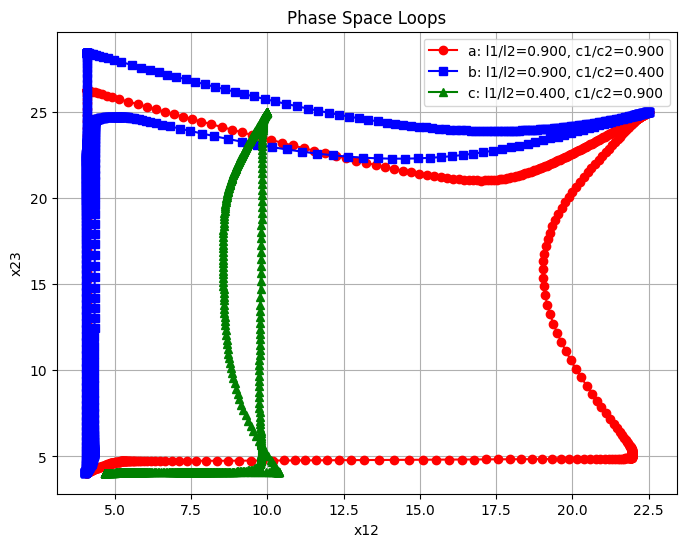

In [8]:
def plot_configuration_space_loops(samples=[(0.9, 0.9), (0.9,0.4), (0.4, 0.9)], colors=['red', 'blue', 'green'], shapes=['o', 's', '^'], labls=['a', 'b', 'c']):
    fig, ax = plt.subplots(figsize=(8,6))
    for (l_ratio, c_ratio), color, shape, labl in zip(samples, colors, shapes, labls):
        l2 = 25.
        l1 = l_ratio * l2
        c2 = 10.
        c1 = c_ratio * c2
        swimmer = Swimmer(l1=l1, l2=l2, c1=c1, c2=c2, check_invariants=False)
        experiment = Experiment(swimmer, b_field=BangBangBField(dbdt=1e-3, b_list=(1., 0.)), n_cycles_max=20, atol=1e-7)
        x0, v, v_error = experiment.find_periodic_state_iteratively()
        sol = experiment.run(n_cycles=1., x0=x0, with_e=False)
        x1 = sol.ys[:,1] - sol.ys[:,0]
        x2 = sol.ys[:,2] - sol.ys[:,1]
        df = pd.DataFrame({'x1': sol.ys[:,0], 'x2': sol.ys[:,1], 'x3': sol.ys[:,2], 't': sol.ts})
        df.to_csv(f'data/trajectory_dbdt_1e3_l2_25_c2_10_lmin_4_lr_{l_ratio:.1f}_cr_{c_ratio:.1f}.csv', index=False)
        ax.plot(x1, x2, color=color, marker=shape, label=f'{labl}: l1/l2={l_ratio:.3f}, c1/c2={c_ratio:.3f}')
    ax.set_xlabel('x12')
    ax.set_ylabel('x23')
    ax.set_title('Phase Space Loops')
    ax.legend()
    ax.grid()

around_critical_point = [(0.3, 0.75),(0.25, 0.75), (0.25, 0.6), (0.3, 0.6)]
three_different_modes = [(0.906, 0.875), (0.9,0.3), (0.3, 0.9)]
plot_configuration_space_loops()

## Optimization

### Evolutionary strategy
using the CMA-ES method

In [31]:
jnp.set_printoptions(precision=3, suppress=True, linewidth=200)

class ESOptimizer(eqx.Module):
    static_params: dict
    initial_guess: dict
    var_params_template: dict
    var_params_leaf_shapes: ArrayLike
    var_params_leaf_sizes: ArrayLike
    lower_param_bounds: ArrayLike
    upper_param_bounds: ArrayLike
    bfield_class: BField
    atol: float
    n_cycles_max: int
    metrics_log: list
    state_history: list
    headstart: float 
    population_history: list

    def __init__(self, 
                 static_params: dict,
                 initial_guess: dict,
                 bfield_class: type = CosBField,
                 atol: float = 1e-4,
                 n_cycles_max: int = 20,
                 lower_bound: dict = None,
                 upper_bound: dict = None,
                 headstart=0.3):
        self.static_params = static_params
        self.initial_guess = initial_guess
        self.bfield_class = bfield_class
        self.atol = atol
        self.n_cycles_max = n_cycles_max
        self.metrics_log = []
        self.state_history = []
        self.population_history = []
        if lower_bound is None:
            self.lower_param_bounds = self.flatten_param_tree(initial_guess) - 1
        if upper_bound is None:
            self.upper_param_bounds = self.flatten_param_tree(initial_guess) + 1
        else:
            self.lower_param_bounds = self.flatten_param_tree(lower_bound)
            self.upper_param_bounds = self.flatten_param_tree(upper_bound)

        self.headstart = headstart
        leaves, self.var_params_template = jax.tree_util.tree_flatten(initial_guess)
        self.var_params_leaf_shapes = [jnp.asarray(l).shape for l in leaves]
        self.var_params_leaf_sizes = jnp.array([jnp.array(jnp.prod(jnp.array(shape)), dtype=int) for shape in self.var_params_leaf_shapes])

    def __hash__(self):
        return hash(str((
            jax.tree.leaves(self.static_params),
            jax.tree.leaves(self.var_params_template),
            jax.tree.leaves(self.upper_param_bounds),
            jax.tree.leaves(self.lower_param_bounds),
            self.bfield_class.__name__,
            self.atol,
            self.n_cycles_max
        )))
    
    def scale(self, var_vector: ArrayLike) -> ArrayLike:
        """Scale variable parameter vector to [0, 1] based on bounds"""
        return (var_vector - self.lower_param_bounds) / (self.upper_param_bounds - self.lower_param_bounds)
    
    def unscale(self, scaled_var_vector: ArrayLike) -> ArrayLike:
        """Unscale variable parameter vector from [0, 1] back to original bounds"""
        return scaled_var_vector * (self.upper_param_bounds - self.lower_param_bounds) + self.lower_param_bounds
    
    def flatten_param_tree(self, param_tree: dict) -> ArrayLike:
        """Flatten nested parameter dictionary into a 1D array"""
        # Get flattened leaves and tree structure
        leaves, treedef = jax.tree_util.tree_flatten(param_tree)

        return jnp.array(leaves, dtype=float)
    
    def unflatten_param_tree(self, flat_array: ArrayLike) -> dict:
        """Reconstruct nested parameter dictionary from a 1D array"""

        return jax.tree_util.tree_unflatten(self.var_params_template, flat_array)
        
    def create_experiment(self, var_vector) -> Experiment:
        """Create experiment from combined static and variable parameters"""
        # Merge static and variable parameters
    
        var_params = self.unflatten_param_tree(var_vector)
        full_swimmer_params = {**self.static_params.get('swimmer', {}), **var_params.get('swimmer', {})}
        full_bfield_params = {**self.static_params.get('bfield', {}), **var_params.get('bfield', {})}

        # Create swimmer and bfield
        swimmer = Swimmer(**full_swimmer_params, check_invariants=False)
        bfield = self.bfield_class(**full_bfield_params)
        
        return Experiment(swimmer, bfield, n_cycles_max=self.n_cycles_max, atol=self.atol)
    
    def velocity(self, var_vector: ArrayLike) -> tuple[float, float]:
        """Compute velocity and residue from variable parameters
        
        Args:
            var_params: Dict with 'swimmer', 'bfield', and 'x0_edges' keys
                       x0_edges contains [x0, x2] (middle is always 0)
        
        Returns:
            (velocity, residue_squared)
        """
        
        experiment = self.create_experiment(var_vector)
        
        _, v, _ = experiment.find_periodic_state_iteratively(headstart=self.headstart)
        
        return v
    
    @partial(jax.jit, static_argnames=("self",))
    def fitness(self, var_vector: ArrayLike):
        v = self.velocity(var_vector)
        return -v

 
    def plot_var_vector(self, var_vector: ArrayLike, **args):
        experiment = self.create_experiment(var_vector)
        x0, _, _ = experiment.find_periodic_state_iteratively(headstart=self.headstart)
        experiment.plot(n_cycles=2, x0=x0, **args)
    
    def plot_optimization_history(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(10,6))

        generations = [metrics["generation_counter"] for metrics in self.metrics_log]
        best_fitness = [metrics["best_fitness"] for metrics in self.metrics_log]
        vars = [jnp.linalg.trace(state.C) for state in self.state_history]
        nan_ratios = [jnp.isnan(population[:, 0]).mean() for population in self.population_history]

        ax.plot(generations, best_fitness, label="Best Fitness", marker="o", markersize=3)
        ax2 = ax.twinx()
        ax2.plot(generations, vars, label="Trace of Covariance", color="orange", marker="s", markersize=3)
        ax2.set_ylabel("Trace of Covariance")
        ax2.set_yscale("log")
        # ax3 = ax.twinx()
        # ax3.plot(generations, nan_ratios)
        ax.set_title("Best fitness and variation of parameters over generations")
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
    
    def optimize(self, es_class=CMA_ES, population_size=32, num_generations=2, seed=42, initial_guess=None, params=None, max_stationary_iterations=10, plot=True, atol=1e-3):
        if initial_guess is None:
            initial_guess = self.initial_guess
        seed = 0
        key = jax.random.key(seed)

        es = es_class(
            population_size=population_size,
            solution=self.flatten_param_tree(initial_guess)
        )

        if params is None:
            params = es.default_params

        # Initialize evolution strategy
        key, subkey = jax.random.split(key)
        state = es.init(subkey, initial_guess, params)

        fitness_vmap = jax.jit(jax.vmap(self.fitness))
        best_fitness = float('inf')
        stationarity_counter = 0

        pbar = tqdm(range(num_generations), desc="ES Optimization")
        for i in pbar:
            key, subkey = jax.random.split(key)
            key_ask, key_tell = jax.random.split(subkey, 2)

            population, state = es.ask(key_ask, state, params)

            population = jnp.clip(population, self.lower_param_bounds, self.upper_param_bounds)

            try:
                fitness = fitness_vmap(population)
            except Exception as e:
                logging.error(f"Error computing fitness at iteration {i}: {e}")
                pbar.close()
                break

            state, metrics = es.tell(key_tell, population, fitness, state, params)

            # Log metrics
            self.metrics_log.append(metrics)
            self.state_history.append(state)
            self.population_history.append(jnp.concat([-fitness.reshape(-1,1), population],axis=1))

            # Update progress bar
            pbar.set_postfix({
                'best_velocity': f"{-metrics['best_fitness']:.7f}",
                'best_parameters': f"{jax.tree_util.tree_map(lambda arr: f"{arr.item():1g}", self.unflatten_param_tree(metrics['best_solution']))}",
            })
            if jnp.linalg.trace(state.C) <= atol**2:
                logging.info(f"Stopping early due to low parameter variation at iteration {i}")
                pbar.close()
                break
            current_best_fitness = metrics['best_fitness']
            if current_best_fitness < best_fitness:
                best_fitness = current_best_fitness
                stationarity_counter = 0
            else:
                stationarity_counter += 1
            if stationarity_counter >= max_stationary_iterations:
                pbar.close()
                logging.info(f"Stopping early due to stationarity at iteration {i}")
                break

        if len(self.metrics_log) == 0:
            raise RuntimeError("No optimization iterations were completed.")
        if plot:
            self.plot_var_vector(self.metrics_log[-1]['best_solution'])

        return -self.metrics_log[-1]['best_fitness'], self.unflatten_param_tree(self.metrics_log[-1]['best_solution'])

### Optimization examples

#### quasistatic

ES Optimization:   0%|          | 0/32 [00:00<?, ?it/s]

/tmp/ipykernel_2945/3066692672.py:189: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)
/tmp/ipykernel_2945/3066692672.py:193: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


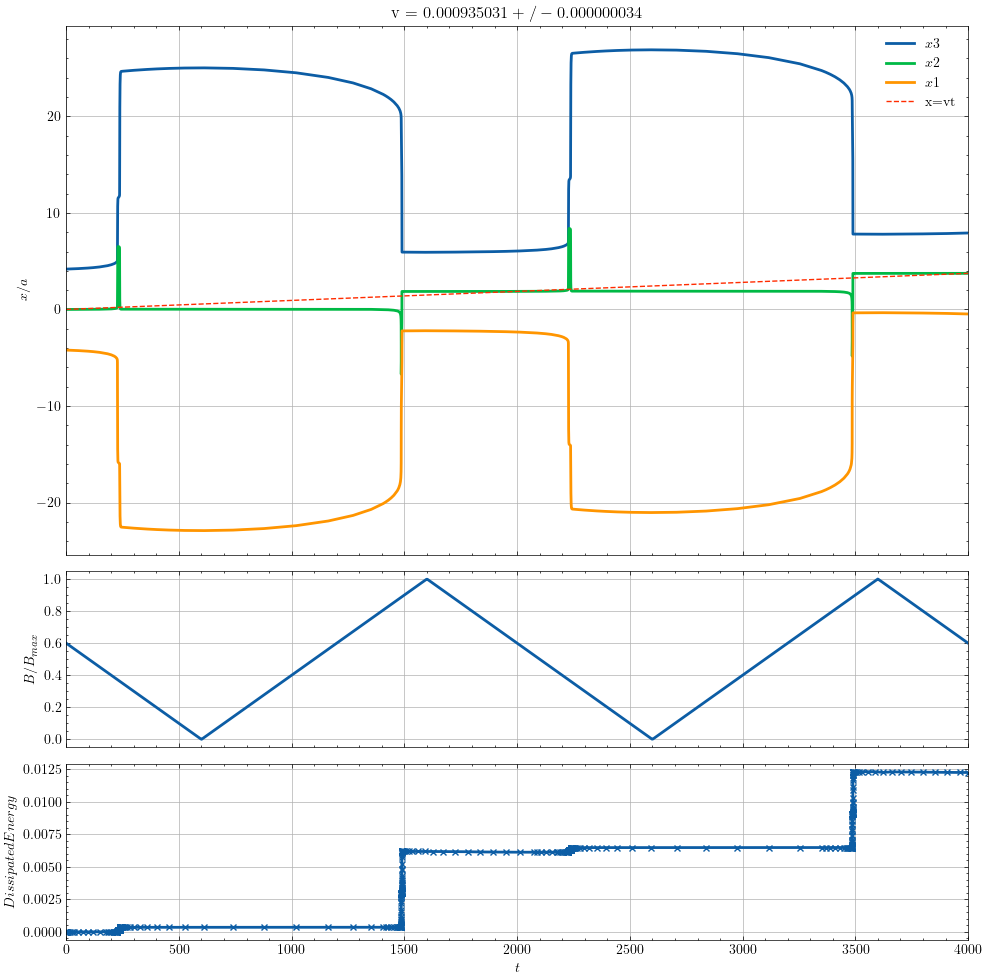

Max instantaneous velocity: 4.357998e-02 m/s at time 1493.262182
Average velocity: 4.251854e-08 m/s 
Reynolds Number: 6.225712e-02
Total dissipated energy per period: 5.805547e-26 J
maximum Magnetic field strength: 9.919198e-02 T
maximum dB/dt: 4.547284e-03 T/s
Field period = 4.398230e+01 s
(Array(0.001, dtype=float64), {'swimmer': {'c1': Array(9.114, dtype=float64), 'l1': Array(22.933, dtype=float64)}})


""

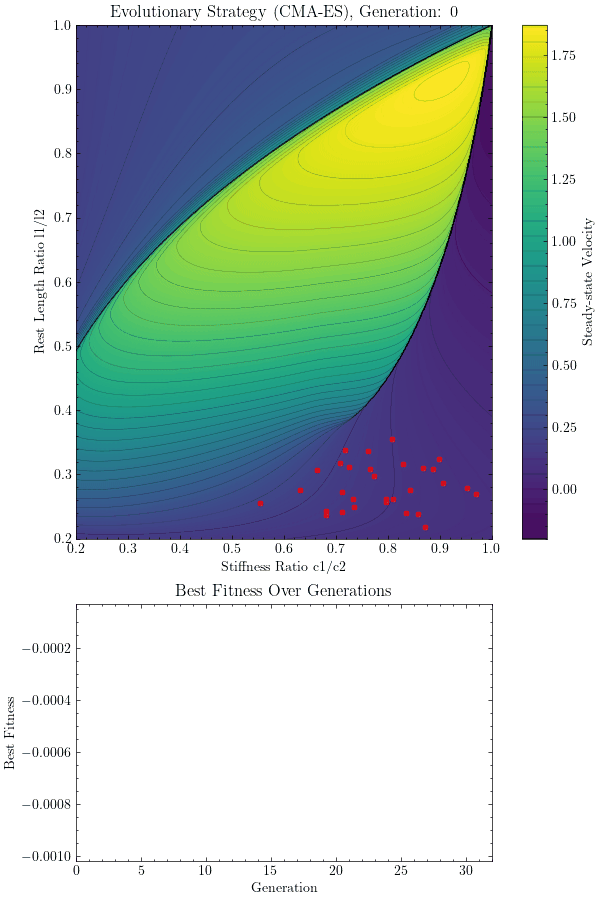

/tmp/ipykernel_2945/3763745621.py:138: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


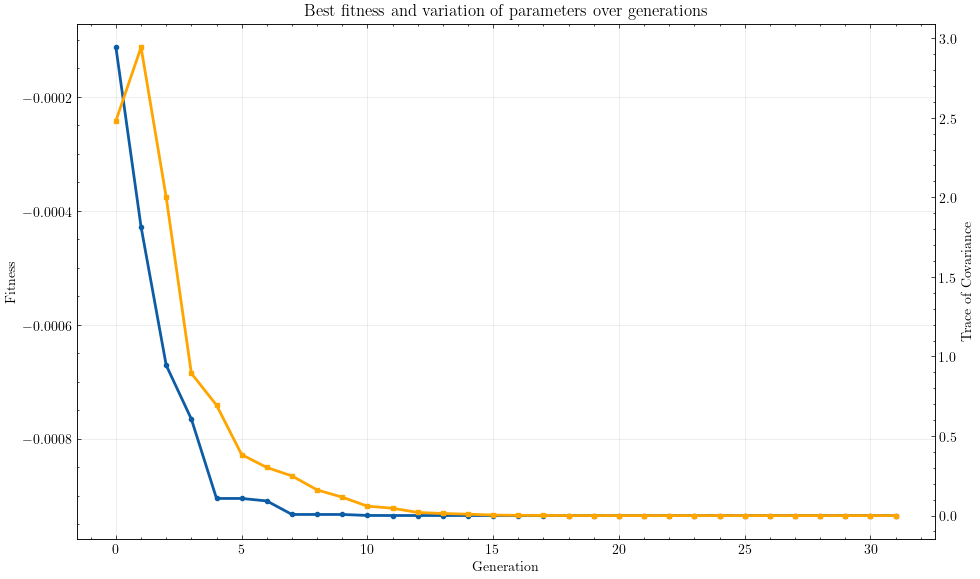

In [30]:
def simple_quasistatic_optimization_example(population_size=32, num_generations=32):
    opt = ESOptimizer(
        static_params={
            'swimmer': {
                'l2': 25.0,
                'c2': 10.0,
            },
            'bfield': {
                'dbdt': 1e-3,
                'b_list': (1.0, 0.0),
                'phi0': 0.2,
            }
        },
        initial_guess={
            'swimmer': {
                'l1': 7.0,
                'c1': 8.0,
            }
        },
        lower_bound={
            'swimmer': {
                'l1': 4.0,
                'c1': 3.0,
            }
        },
        upper_bound={
            'swimmer': {
                'l1': 25.0,
                'c1': 10.0,
            }
        },
        bfield_class=BangBangBField,
        atol=1e-4,
        n_cycles_max=20,
        headstart=0.3
    )
    print(opt.optimize(population_size=population_size, num_generations=num_generations))


    # Create figure and axis
    fig, (ax, ax_fitness) = plt.subplots(2, figsize=(6, 9), height_ratios=[2, 1])

    plot_velocity_vs_parameters(ax=ax, samples=None, verbose=False)
    # Adjust based on expected position range
    # Adjust based on expected position range

    # Extract population trajectory from states
    populations = jnp.array(opt.population_history)/jnp.array([10.,25.])  # Shape: (num_generations, population_size, num_dims)
    best_fitness = jnp.array([metrics["best_fitness"] for metrics in opt.metrics_log])

    # Create a scatter plot for the population
    scatter = ax.scatter([], [], color="r", s=10)

    fitness_plot = ax_fitness.plot([], [], color="red")[0]
    ax_fitness.set_title("Best Fitness Over Generations")
    ax_fitness.set_xlabel("Generation")
    ax_fitness.set_ylabel("Best Fitness")
    ax_fitness.set_xlim(0, len(opt.metrics_log))
    min_fitness = min(best_fitness)
    max_fitness = max(best_fitness)
    delta_fitness = max_fitness - min_fitness
    ax_fitness.set_ylim(min_fitness - 0.1 * delta_fitness, max_fitness + 0.1 * delta_fitness)

    # Add a title with generation counter
    title = ax.set_title("Evolutionary Strategy (CMA-ES), Generation: 0")


    def init():
        scatter.set_offsets(jnp.empty((0, 2)))
        return scatter, title


    def update(frame):
        # Update the positions of the population
        # populations[frame] has shape (population_size, num_dims)
        scatter.set_offsets(populations[frame])
        fitness_plot.set_data(
            jnp.arange(frame + 1),
            best_fitness[: frame + 1]
        )

        # Update the title with current generation
        title.set_text(f"Evolutionary Strategy (CMA-ES), Generation: {frame}")

        return scatter, title


    # Create the animation
    anim = animation.FuncAnimation(
        fig, update, frames=len(populations), init_func=init, blit=True
    )

    plt.close()

    # Create a writer
    path = "simple_quasistatic_ES_optimization.gif"
    anim.save(path, writer=PillowWriter())

    # Display the GIF in the notebook
    mediapy.show_video(mediapy.read_video(path), fps=4, codec="gif")

    opt.plot_optimization_history()
    return opt

opt = simple_quasistatic_optimization_example()


#### with BangBangBField

ES Optimization:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_4657/2287472661.py:192: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)
/tmp/ipykernel_4657/2287472661.py:196: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


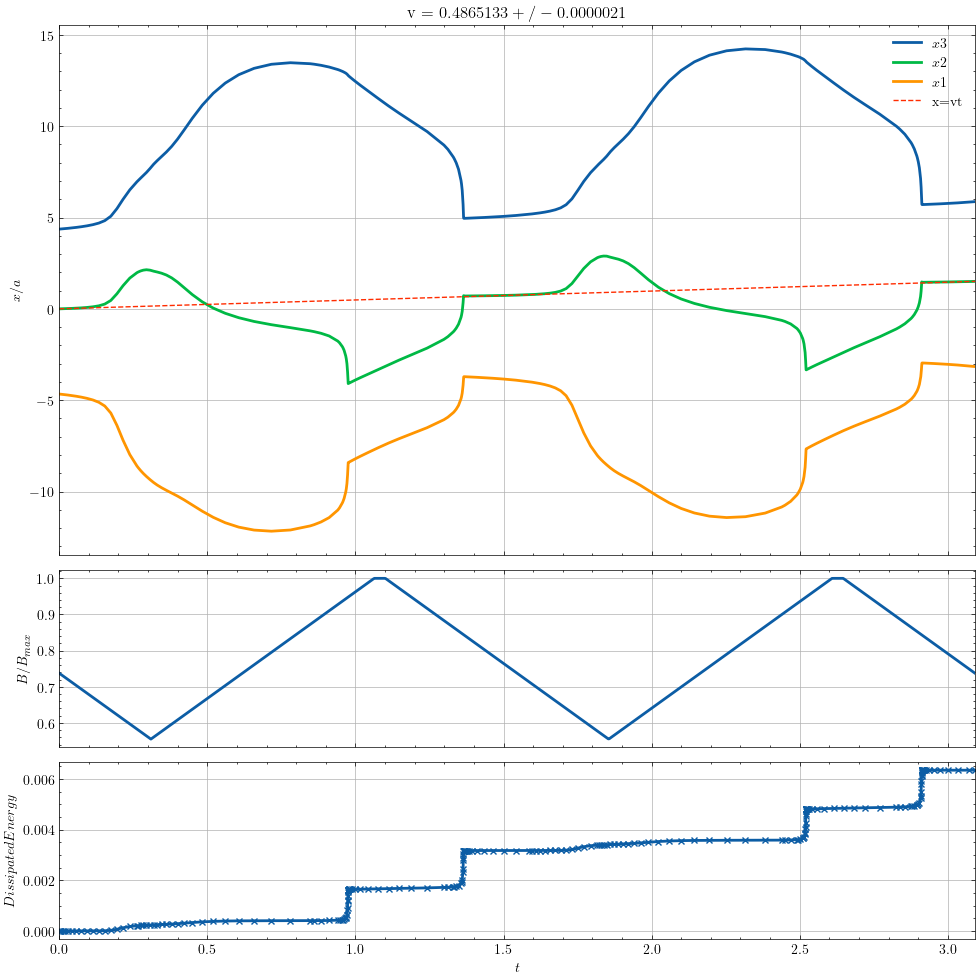

Max instantaneous velocity: 2.148052e-02 m/s at time 0.780562
Average velocity: 2.212314e-05 m/s 
Reynolds Number: 6.137292e-02
Total dissipated energy per period: 3.005298e-26 J
maximum Magnetic field strength: 1.000000e-01 T
maximum dB/dt: 2.682898e+00 T/s
Field period = 3.399587e-02 s


/tmp/ipykernel_4657/3844764411.py:142: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


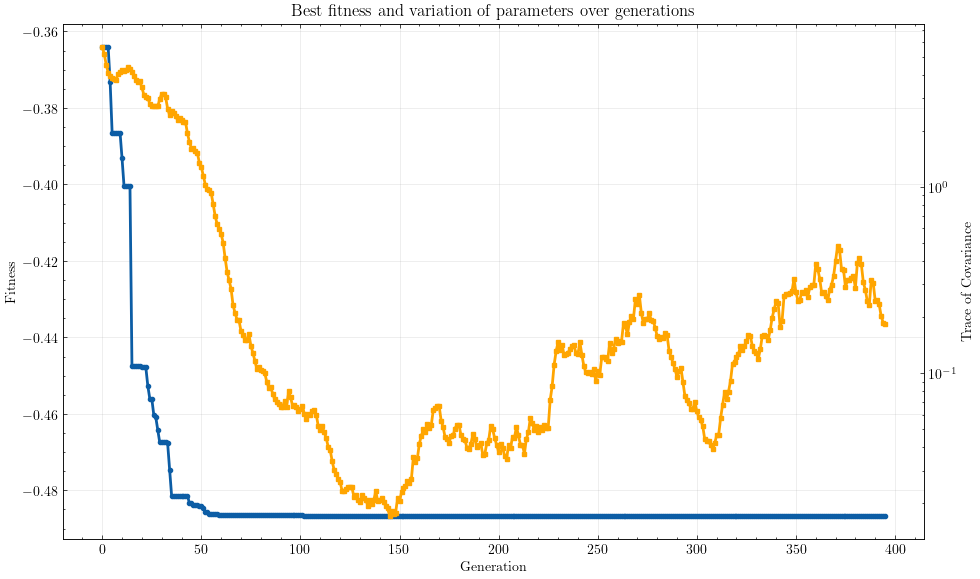

In [7]:
def full_bangbang_optimization(population_size=32, num_generations=128):
    opt = ESOptimizer(
        static_params={
            'bfield': {
                'phi0': 0.3,
                'dbdt': 0.59,
                'b_clip': 1.,
            }
        },
        initial_guess={
            'swimmer': {
                'c1': 6.5,
                'c2': 7.6,
                'l1': 13.0,
                'l2': 19.8,
            },
            'bfield': {
                'b_list': (1.2, 0.5),
            }
        },
        lower_bound={
            'swimmer': {
                'l1': 4.0,
                'l2': 4.0,
                'c1': 2.0,
                'c2': 2.0,
            },
            'bfield': {
                'b_list': (0.5, -1),
            }
        },
        upper_bound={
            'swimmer': {
                'l1': 50.0,
                'l2': 50.0,
                'c1': 12.0,
                'c2': 12.0,
            },
            'bfield': {
                'b_list': (4.0, 0.8),
            }
        },
        bfield_class=BangBangBField,
        atol=1e-4,
        n_cycles_max=20,
        headstart=0.3
    )
    opt.optimize(population_size=population_size, num_generations=num_generations, max_stationary_iterations=num_generations//4)
    opt.plot_optimization_history()
    return opt
    

opt3 = full_bangbang_optimization(num_generations=512)


#### slightly weaker, fixed fields

In [29]:
def full_bangbang_optimization(population_size=32, num_generations=128):
    opt = ESOptimizer(
        static_params={
            'bfield': {
                'phi0': 0.3,
                'dbdt': 0.59,
                'b_clip': 1.,
                'b_list': (0.9, 0.45),
            }
        },
        initial_guess={
            'swimmer': {
                'c1': 6.5,
                'c2': 7.6,
                'l1': 13.0,
                'l2': 19.8,
            }
        },
        lower_bound={
            'swimmer': {
                'l1': 4.0,
                'l2': 4.0,
                'c1': 2.0,
                'c2': 2.0,
            }
        },
        upper_bound={
            'swimmer': {
                'l1': 50.0,
                'l2': 50.0,
                'c1': 12.0,
                'c2': 12.0,
            }
        },
        bfield_class=BangBangBField,
        atol=1e-4,
        n_cycles_max=20,
        headstart=0.3
    )
    opt.optimize(population_size=population_size, num_generations=num_generations, max_stationary_iterations=num_generations//4)
    opt.plot_optimization_history()
    return opt
    

opt4 = full_bangbang_optimization(num_generations=512)


NameError: name 'ESOptimizer' is not defined

#### much weaker fields

ES Optimization:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_51701/844300446.py:192: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)
/tmp/ipykernel_51701/844300446.py:196: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


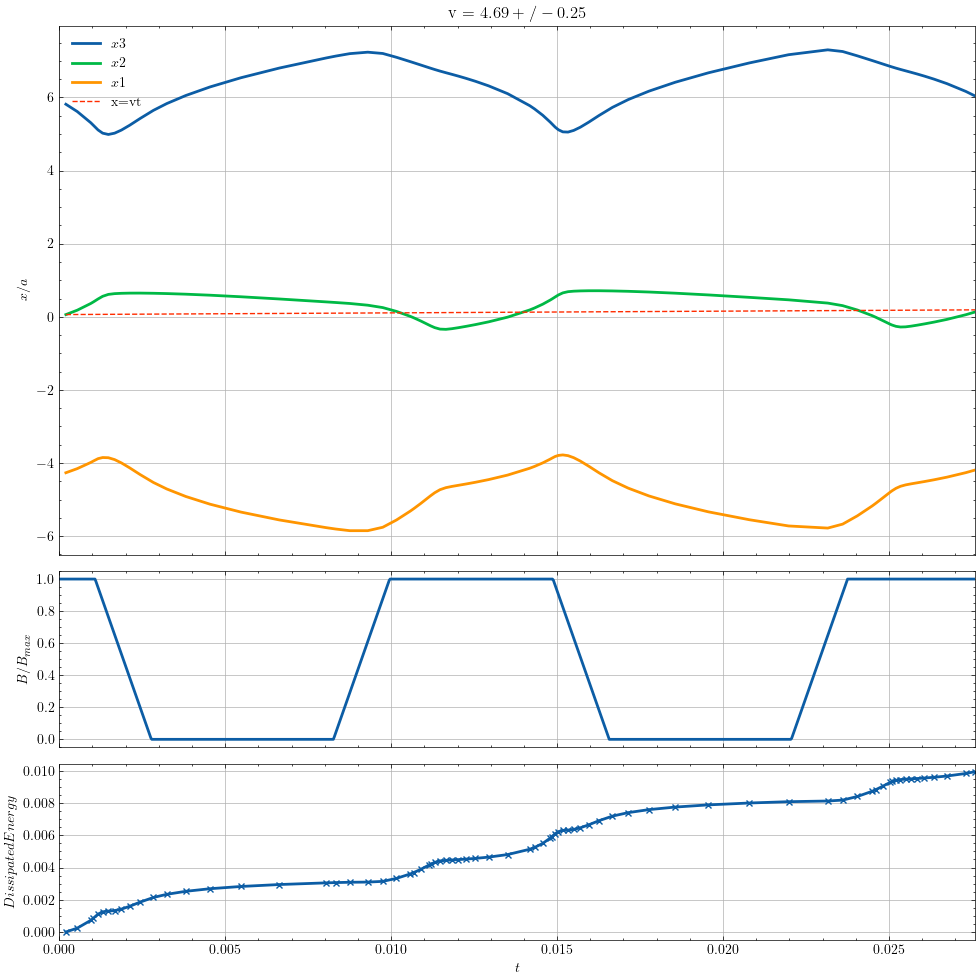

Max instantaneous velocity: 3.239735e-02 m/s at time 0.000543
Average velocity: 2.133439e-04 m/s 
Reynolds Number: 9.256387e-02
Total dissipated energy per period: 2.983429e-14 J
maximum Magnetic field strength: 1.000000e-01 T
maximum dB/dt: 2.682898e+03 T/s
Field period = 3.033947e-04 s and frequency = 3.296036e+03 Hz
spring constants: k1 = 1.517462e-03 N/m, k2 = 2.733111e-05 N/m


/tmp/ipykernel_51701/3844764411.py:142: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


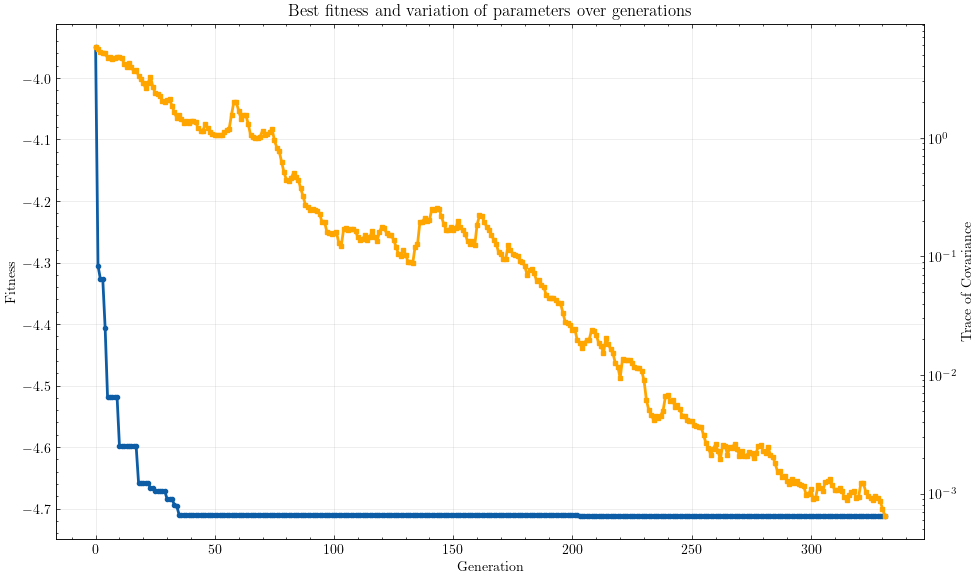

In [37]:
def full_bangbang_optimization(population_size=32, num_generations=128):
    opt = ESOptimizer(
        static_params={
            'bfield': {
                'phi0': 0.1,
                'dbdt': 590,
                'b_clip': 1.,
            }
        },
        initial_guess={
            'swimmer': {
                'c1': 3.5,
                'c2': 14.,
                'l1': 6.0,
                'l2': 18.,
            },
            'bfield': {
                'b_list': (2.5, -1.5),
            }
        },
        lower_bound={
            'swimmer': {
                'l1': 4.0,
                'l2': 4.0,
                'c1': 0.2,
                'c2': 0.2,
            },
            'bfield': {
                'b_list': (0.5, -5),
            }
        },
        upper_bound={
            'swimmer': {
                'l1': 50.0,
                'l2': 50.0,
                'c1': 25.0,
                'c2': 25.0,
            },
            'bfield': {
                'b_list': (6, 0.8),
            }
        },
        bfield_class=BangBangBField,
        atol=1e-4,
        n_cycles_max=20,
        headstart=0.3
    )
    opt.optimize(population_size=population_size, num_generations=num_generations, max_stationary_iterations=num_generations//4)
    opt.plot_optimization_history()
    return opt
    

opt6 = full_bangbang_optimization(num_generations=512)


#### with CosBField

ES Optimization:   0%|          | 0/512 [00:00<?, ?it/s]

/tmp/ipykernel_14818/622525983.py:192: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0, wspace=0)
/tmp/ipykernel_14818/622525983.py:196: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


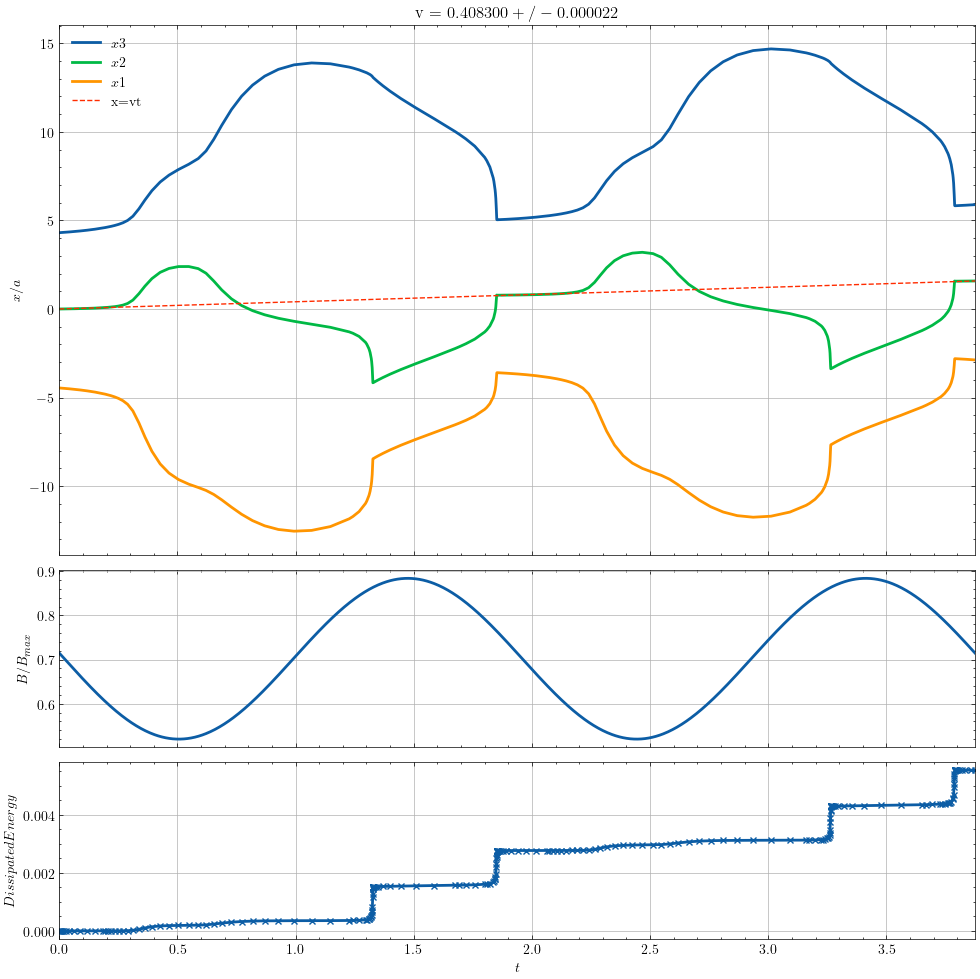

Max instantaneous velocity: 1.965730e-02 m/s at time 3.265504
Average velocity: 1.856655e-05 m/s 
Reynolds Number: 2.808186e-02
Total dissipated energy per period: 2.621953e-26 J
maximum Magnetic field strength: 8.838755e-02 T
maximum dB/dt: 2.682743e+00 T/s
Field period = 4.260239e-02 s
(Array(0.408, dtype=float64), {'bfield': {'b_max': Array(0.884, dtype=float64), 'b_min': Array(0.52, dtype=float64), 'dbdt': Array(0.59, dtype=float64)}, 'swimmer': {'c1': Array(6.633, dtype=float64), 'c2': Array(8.219, dtype=float64), 'l1': Array(13.702, dtype=float64), 'l2': Array(17., dtype=float64)}})


/tmp/ipykernel_14818/3844764411.py:142: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


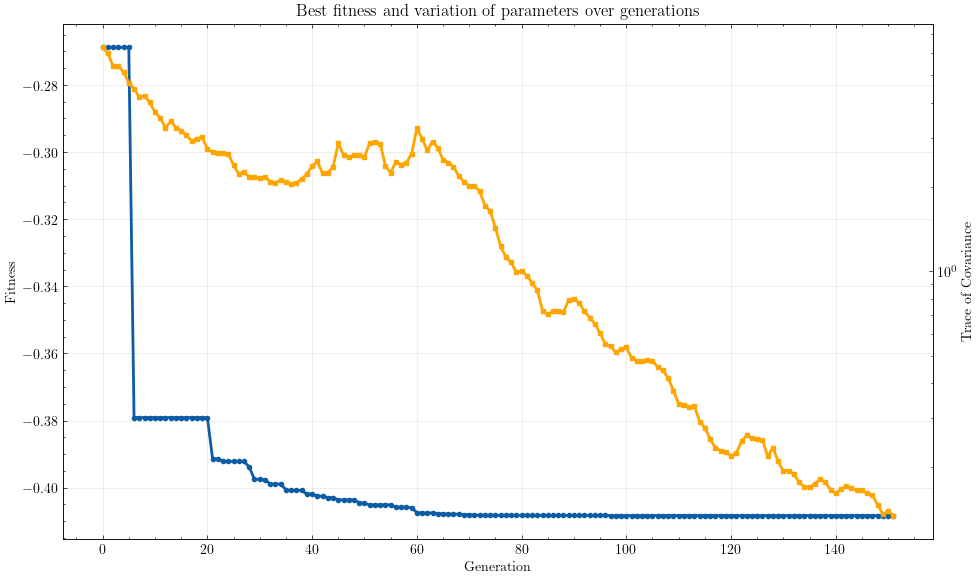

In [66]:
def full_cos_optimization(population_size=32, num_generations=128):
    opt = ESOptimizer(
        static_params={
            'bfield': {
                'phi0': 1.5,
            }
        },
        initial_guess={
            'swimmer': {
                'c1': 6.6,
                'c2': 8.2,
                'l1': 13.7,
                'l2': 17.,
            },
            'bfield': {
                'b_min': 0.52,
                'b_max': 0.88,
                'dbdt': 0.59,
            }
        },
        lower_bound={
            'swimmer': {
                'l1': 4.0,
                'l2': 4.0,
                'c1': 2.0,
                'c2': 2.0,
            },
            'bfield': {
                'b_min': -1.,
                'b_max': 0.6,
                'dbdt': 0.3,
            }
        },
        upper_bound={
            'swimmer': {
                'l1': 50.0,
                'l2': 50.0,
                'c1': 12.0,
                'c2': 12.0,
            },
            'bfield': {
                'b_min': 0.9,
                'b_max': 1.0,
                'dbdt': 0.59,
            }
        },
        bfield_class=CosBField,
        atol=1e-4,
        n_cycles_max=20,
        headstart=0.3
    )
    print(opt.optimize(population_size=population_size, num_generations=num_generations, max_stationary_iterations=20))
    opt.plot_optimization_history()
    return opt
    

opt4 = full_cos_optimization(num_generations=512)


In [33]:
ex = Experiment(Swimmer(c1=6.63, c2=8.22, l1=13.7, l2=17.), CosBField(dbdt=0.59, b_min = 0.52, b_max = 0.884, phi0=1.5), atol=1e-6)
# x0, v, verr = ex.find_periodic_state_iteratively(headstart=0.3, order=6)
# print(v, verr)
# sol = ex.run(n_cycles=1, x0=x0, with_e=False)
# df = pd.DataFrame({'t': sol.ts, 'x1': sol.ys[:,0], 'x2': sol.ys[:,1], 'x3': sol.ys[:,2], 'h': ex.b_field(sol.ts)})
# df.to_csv(f'data/trajectory_cos_opt.csv', index=False)
ex.swimmer.k1 * ex.spring_constant_scale, ex.swimmer.k2 * ex.spring_constant_scale

(1.3016123812157373e-16, 5.485272266846333e-17)

### gradient based

now we use the jax autodiff framework to do gradient based optimization of the Swimmer and BField parameters

not so successfull

In [76]:
class Optimizer(eqx.Module):
    static_swimmer_params: dict
    static_bfield_params: dict
    bfield_class: type
    lambda_param: float
    atol: float
    fix_x0: bool
    n_cycles_max: int
    history: list
    headstart: float

    def __init__(self, 
                 static_swimmer_params: dict,
                 static_bfield_params: dict,
                 bfield_class: type = CosBField,
                 lambda_param: float = 1.0,
                 atol: float = 1e-4,
                 n_cycles_max: int = 20,
                 fix_x0=False,
                 headstart=0.3):
        self.static_swimmer_params = static_swimmer_params
        self.static_bfield_params = static_bfield_params
        self.bfield_class = bfield_class
        self.lambda_param = lambda_param
        self.atol = atol
        self.fix_x0 = fix_x0
        self.n_cycles_max = n_cycles_max
        self.history = []
        self.headstart = 0.3
    
    def create_experiment(self, swimmer_params: dict, bfield_params: dict) -> Experiment:
        """Create experiment from combined static and variable parameters"""
        # Merge static and variable parameters
        full_swimmer_params = {**self.static_swimmer_params, **swimmer_params}
        full_bfield_params = {**self.static_bfield_params, **bfield_params}
        
        # Create swimmer and bfield
        swimmer = Swimmer(**full_swimmer_params, check_invariants=False)
        bfield = self.bfield_class(**full_bfield_params)
        
        return Experiment(swimmer, bfield, n_cycles_max=self.n_cycles_max, atol=self.atol)
    
    def multiobjective_fn(self, var_params: dict) -> tuple[float, float]:
        """Compute velocity and residue from variable parameters
        
        Args:
            var_params: Dict with 'swimmer', 'bfield', and 'x0_edges' keys
                       x0_edges contains [x0, x2] (middle is always 0)
        
        Returns:
            (velocity, residue_squared)
        """
        # Reconstruct full x0 with middle at 0
        x0 = jnp.array([var_params['x0_edges'][0], 0.0, var_params['x0_edges'][1]])
        
        # Create experiment with current parameters
        experiment = self.create_experiment(var_params['swimmer'], var_params['bfield'])
        
        # Compute velocity and residue
        v, residue_sq = experiment.velocity_and_residue(x0=x0, headstart=self.headstart)
        
        return v, residue_sq
    
    def loss_fn(self, var_params: dict) -> tuple[float, dict]:
        """Compute loss = -velocity + lambda * residue_squared"""
        v, residue_sq = self.multiobjective_fn(var_params)
        loss = -v + self.lambda_param * residue_sq
        return loss, {'velocity': v, 'residue_sq': residue_sq}
    
    def optimize(self, 
                 initial_swimmer_params: dict,
                 initial_bfield_params: dict,
                 initial_x0: ArrayLike = None,
                 optim: optax.GradientTransformation = None,
                 max_steps: int = 1000) -> dict:
        """Run optimization"""
        if optim is None:
            optim = optax.adam(learning_rate=0.01)
        
        # Find initial x0 if not provided
        if initial_x0 is None:
            logging.info("Finding initial periodic state...")
            exp_init = self.create_experiment(initial_swimmer_params, initial_bfield_params)
            x0_init = exp_init.swimmer.x_collapse_approx(exp_init.b_field(-self.headstart * exp_init.b_field.period))
            logging.info(f"Initial x0 found: {x0_init}")
        else:
            x0_init = jnp.array(initial_x0) - initial_x0[1]
        
        # Create initial variable parameters (only x0[0] and x0[2], x0[1]=0 is fixed)
        var_params = {
            'swimmer': initial_swimmer_params,
            'bfield': initial_bfield_params,
            'x0_edges': jnp.array([x0_init[0], x0_init[2]])
        }
        
        # All parameters are optimizable
        opt_params = var_params
        
        # Value and grad function - use standard JAX instead of eqx.filter
        @jax.jit
        def value_and_grad_fn(params):
            return jax.value_and_grad(self.loss_fn, has_aux=True)(params)
        
        # Initialize optimizer state
        opt_state = optim.init(opt_params)
        
        # Log optimization start
        logging.info(f"Starting optimization with lambda={self.lambda_param}, max_steps={max_steps}")
        logging.info(f"Variable swimmer params: {list(initial_swimmer_params.keys())}")
        logging.info(f"Variable bfield params: {list(initial_bfield_params.keys())}")
        logging.info(f"Optimizing x0[0] and x0[2], keeping x0[1]=0 fixed")
        
        # Optimization loop
        pbar = tqdm(range(max_steps), desc="Optimizing")
        for step in pbar:
            try:
                (loss, aux), grads = value_and_grad_fn(opt_params)
            except Exception as e:
                logging.error(f'could not process swimmer with params {opt_params}, error: {e}')
                break
            
            # Update parameters
            updates, opt_state = optim.update(grads, opt_state, opt_params)
            opt_params = optax.apply_updates(opt_params, updates)
            
            # Store history
            self.history.append({
                'step': step,
                'loss': float(loss),
                'velocity': float(aux['velocity']),
                'residue_sq': float(aux['residue_sq']),
                'swimmer': opt_params['swimmer'],
                'bfield': opt_params['bfield'],
                'x0': jnp.array([opt_params['x0_edges'][0], 0.0, opt_params['x0_edges'][1]])
            })
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f"{loss:.6f}",
                'v': f"{aux['velocity']:.6f}",
                'res²': f"{aux['residue_sq']:.2e}"
            })
            
            # Check convergence
            if step > 0 and abs(self.history[-1]['loss'] - self.history[-2]['loss']) < 1e-12:
                logging.info(f"Converged at step {step}!")
                pbar.close()
                break
        
        # Reconstruct final x0
        x0_final = jnp.array([opt_params['x0_edges'][0], 0.0, opt_params['x0_edges'][1]])
        
        logging.info(f"Optimization complete. Final v={aux['velocity']:.6f}, res²={aux['residue_sq']:.6e}")
        
        return {
            'swimmer': opt_params['swimmer'],
            'bfield': opt_params['bfield'],
            'x0': x0_final
        }
    
    def plot_training_history(self, param_names: list[str] = None):
        """Plot training history
        
        Args:
            param_names: List of parameter paths (e.g., ['swimmer.l1', 'bfield.b_max', 'x0.0'])
        """
        if not self.history:
            logging.warning("No history to plot. Run optimize() first.")
            return
        
        steps = [h['step'] for h in self.history]
        losses = [h['loss'] for h in self.history]
        velocities = [h['velocity'] for h in self.history]
        residues = [h['residue_sq'] for h in self.history]
        
        # Default: include x0 edges
        if param_names is None:
            param_names = []
        for x0_param in ['x0.0', 'x0.2']:
            if x0_param not in param_names:
                param_names.append(x0_param)
        
        # Create figure
        fig, (ax_metrics, ax_params) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
        
        # Top: Metrics
        ax_metrics.plot(steps, losses, marker='o', markersize=2, color='C0', label='Loss')
        ax_metrics.set_ylabel('Loss', color='C0')
        ax_metrics.tick_params(axis='y', labelcolor='C0')
        ax_metrics.set_title('Optimization Progress')
        ax_metrics.grid(True, alpha=0.3)
        
        ax_vel = ax_metrics.twinx()
        ax_vel.spines['right'].set_position(('outward', 0))
        ax_vel.plot(steps, velocities, marker='s', markersize=2, color='C1', 
                    alpha=0.7, linestyle='--', label='Velocity')
        ax_vel.set_ylabel('Velocity', color='C1')
        ax_vel.tick_params(axis='y', labelcolor='C1')
        ax_vel.spines['right'].set_color('C1')
        
        ax_res = ax_metrics.twinx()
        ax_res.spines['right'].set_position(('outward', 60))
        ax_res.plot(steps, residues, marker='^', markersize=2, color='C2',
                    alpha=0.7, linestyle=':', label='Residue²')
        ax_res.set_ylabel('Residue²', color='C2')
        ax_res.tick_params(axis='y', labelcolor='C2')
        ax_res.set_yscale('log')
        ax_res.spines['right'].set_color('C2')
        
        lines1, labels1 = ax_metrics.get_legend_handles_labels()
        lines2, labels2 = ax_vel.get_legend_handles_labels()
        lines3, labels3 = ax_res.get_legend_handles_labels()
        ax_metrics.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left')
        
        # Bottom: Parameters
        if param_names:
            colors = plt.cm.tab10(np.linspace(0, 1, len(param_names)))
            
            for idx, param_name in enumerate(param_names):
                param_values = []
                for h in self.history:
                    parts = param_name.split('.')
                    val = h
                    for part in parts:
                        if part.isdigit():
                            val = val[int(part)]
                        elif isinstance(val, dict):
                            val = val.get(part, 0.)
                        else:
                            val = getattr(val, part)
                    param_values.append(float(val))
                
                color = colors[idx]
                
                if idx == 0:
                    ax_params.plot(steps, param_values, marker='o', markersize=2,
                                  color=color, alpha=0.7, label=param_name)
                    ax_params.set_ylabel(param_name, color=color)
                    ax_params.tick_params(axis='y', labelcolor=color)
                    ax_params.grid(True, alpha=0.3)
                else:
                    ax_param = ax_params.twinx()
                    ax_param.spines['right'].set_position(('outward', 60 * (idx - 1)))
                    ax_param.plot(steps, param_values, marker='s', markersize=2,
                                 color=color, alpha=0.7, linestyle='--', label=param_name)
                    ax_param.set_ylabel(param_name, color=color)
                    ax_param.tick_params(axis='y', labelcolor=color)
                    ax_param.spines['right'].set_color(color)
            
            ax_params.legend(loc='upper left')
        
        ax_params.set_xlabel('Training Step')
        fig.tight_layout()
        plt.show()

### Optimization Example
Example of optimizing swimmer and bfield parameters

not really working...

INFO:root:Periodic state found: [-3.16859694  0.          3.09399536] with residue [-7.35778505e-08 -2.78181647e-08] after 1 cycles


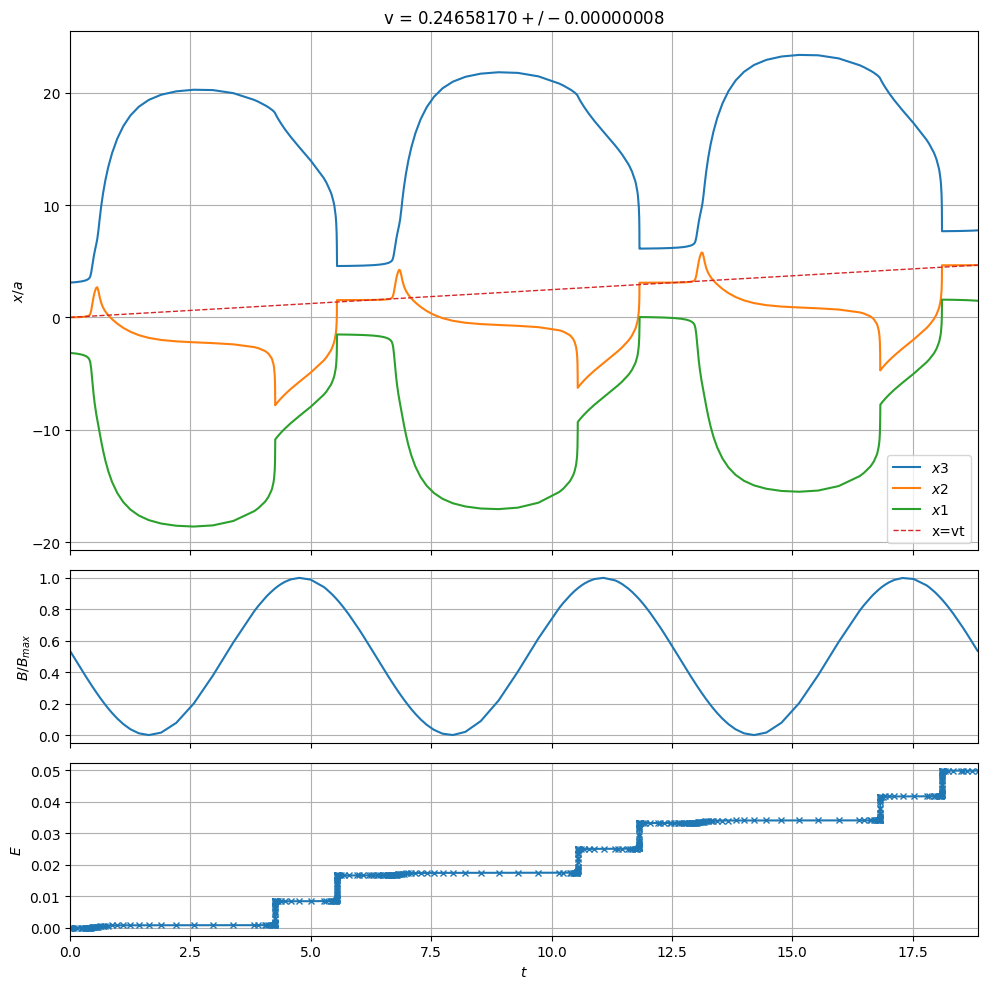

In [71]:
ex = Experiment(Swimmer(), CosBField(dbdt=1))
ex.plot()

INFO:root:Finding initial periodic state...
INFO:root:Initial x0 found: [-14.43710811   0.          20.53288851]
INFO:root:Starting optimization with lambda=0.1, max_steps=1000
INFO:root:Variable swimmer params: []
INFO:root:Variable bfield params: ['b_min']
INFO:root:Optimizing x0[0] and x0[2], keeping x0[1]=0 fixed


Optimizing:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Optimization complete. Final v=-0.000332, res²=1.149051e-01


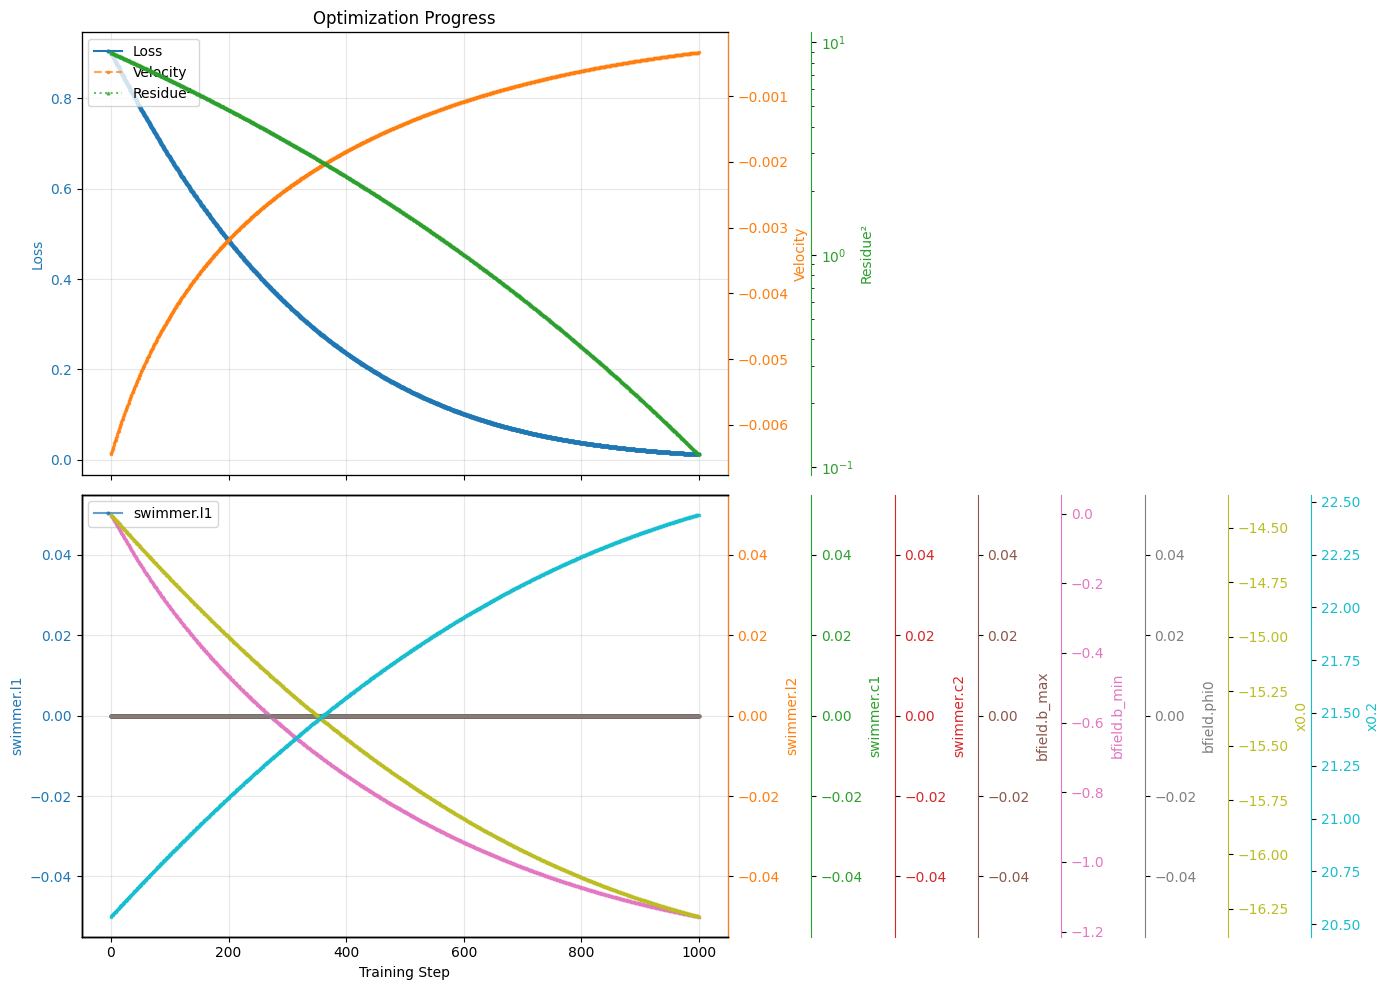

In [77]:
# Create optimizer with static and variable parameter specification
optimizer = Optimizer(
    static_swimmer_params={'lmin': 3.0},  # Keep lmin fixed
    static_bfield_params={'dbdt': 1.0},   # Keep dbdt fixed
    bfield_class=CosBField,
    lambda_param=1e-1,
    atol=1e-3,
    n_cycles_max=20
)

# Initial values for variable parameters
initial_swimmer = {}
initial_bfield = {'b_min': 0.}

# Run optimization
optimized = optimizer.optimize(
    initial_swimmer_params=initial_swimmer,
    initial_bfield_params=initial_bfield,
    optim=optax.adam(learning_rate=0.001),
    max_steps=1000
)

# Plot results
optimizer.plot_training_history(param_names=['swimmer.l1', 'swimmer.l2', 'swimmer.c1', 'swimmer.c2', 
                                              'bfield.b_max', 'bfield.b_min', 'bfield.phi0'])

In [ ]:
# Visualize optimized swimmer
swimmer_opt = Swimmer(**{**optimizer.static_swimmer_params, **optimized['swimmer']})
bfield_opt = optimizer.bfield_class(**{**optimizer.static_bfield_params, **optimized['bfield']})
ex_opt = Experiment(swimmer_opt, bfield_opt, n_cycles_max=20, atol=1e-3)

ex_opt.plot(n_cycles=2, x0=optimized['x0'], 
            display_swimmer_times=jnp.linspace(0, 2*bfield_opt.period, 5))